# Background

# Data

The data for this data set was pulled from here on kaggle old: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset


new and cleaned: 
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset


challenge: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system

https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf




In [364]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [368]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [346]:
diab_df = pd.read_csv('diabetes_binary_5050_DR_BRFSS2015.csv')

diab_df.head()

,Diabetes_binary,HighBP,Asthma,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,ALCDAY5,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,Employed,PhysHlth,DiffWalk,Sex,Age,Chronic_Cancer,Education,Weight (lbs),Income
0,0.0,0.0,0.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,9.0,0.0,4.0,180.0,8.0
1,0.0,1.0,0.0,1.0,1.0,23.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,2.0,1.0,1.0,1.0,11.0,0.0,6.0,160.0,6.0
2,0.0,0.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,21.0,0.0,0.0,7.0,0.0,6.0,152.0,7.0
3,0.0,1.0,0.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,12.0,1.0,6.0,189.0,7.0
4,0.0,0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,5.0,185.0,5.0


In [347]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70252 entries, 0 to 70251
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70252 non-null  float64
 1   HighBP                70252 non-null  float64
 2   Asthma                70252 non-null  float64
 3   HighChol              70252 non-null  float64
 4   CholCheck             70252 non-null  float64
 5   BMI                   70252 non-null  float64
 6   Smoker                70252 non-null  float64
 7   Stroke                70252 non-null  float64
 8   HeartDiseaseorAttack  70252 non-null  float64
 9   PhysActivity          70252 non-null  float64
 10  Fruits                70252 non-null  float64
 11  Veggies               70252 non-null  float64
 12  HvyAlcoholConsump     70252 non-null  float64
 13  ALCDAY5               70252 non-null  float64
 14  AnyHealthcare         70252 non-null  float64
 15  NoDocbcCost        

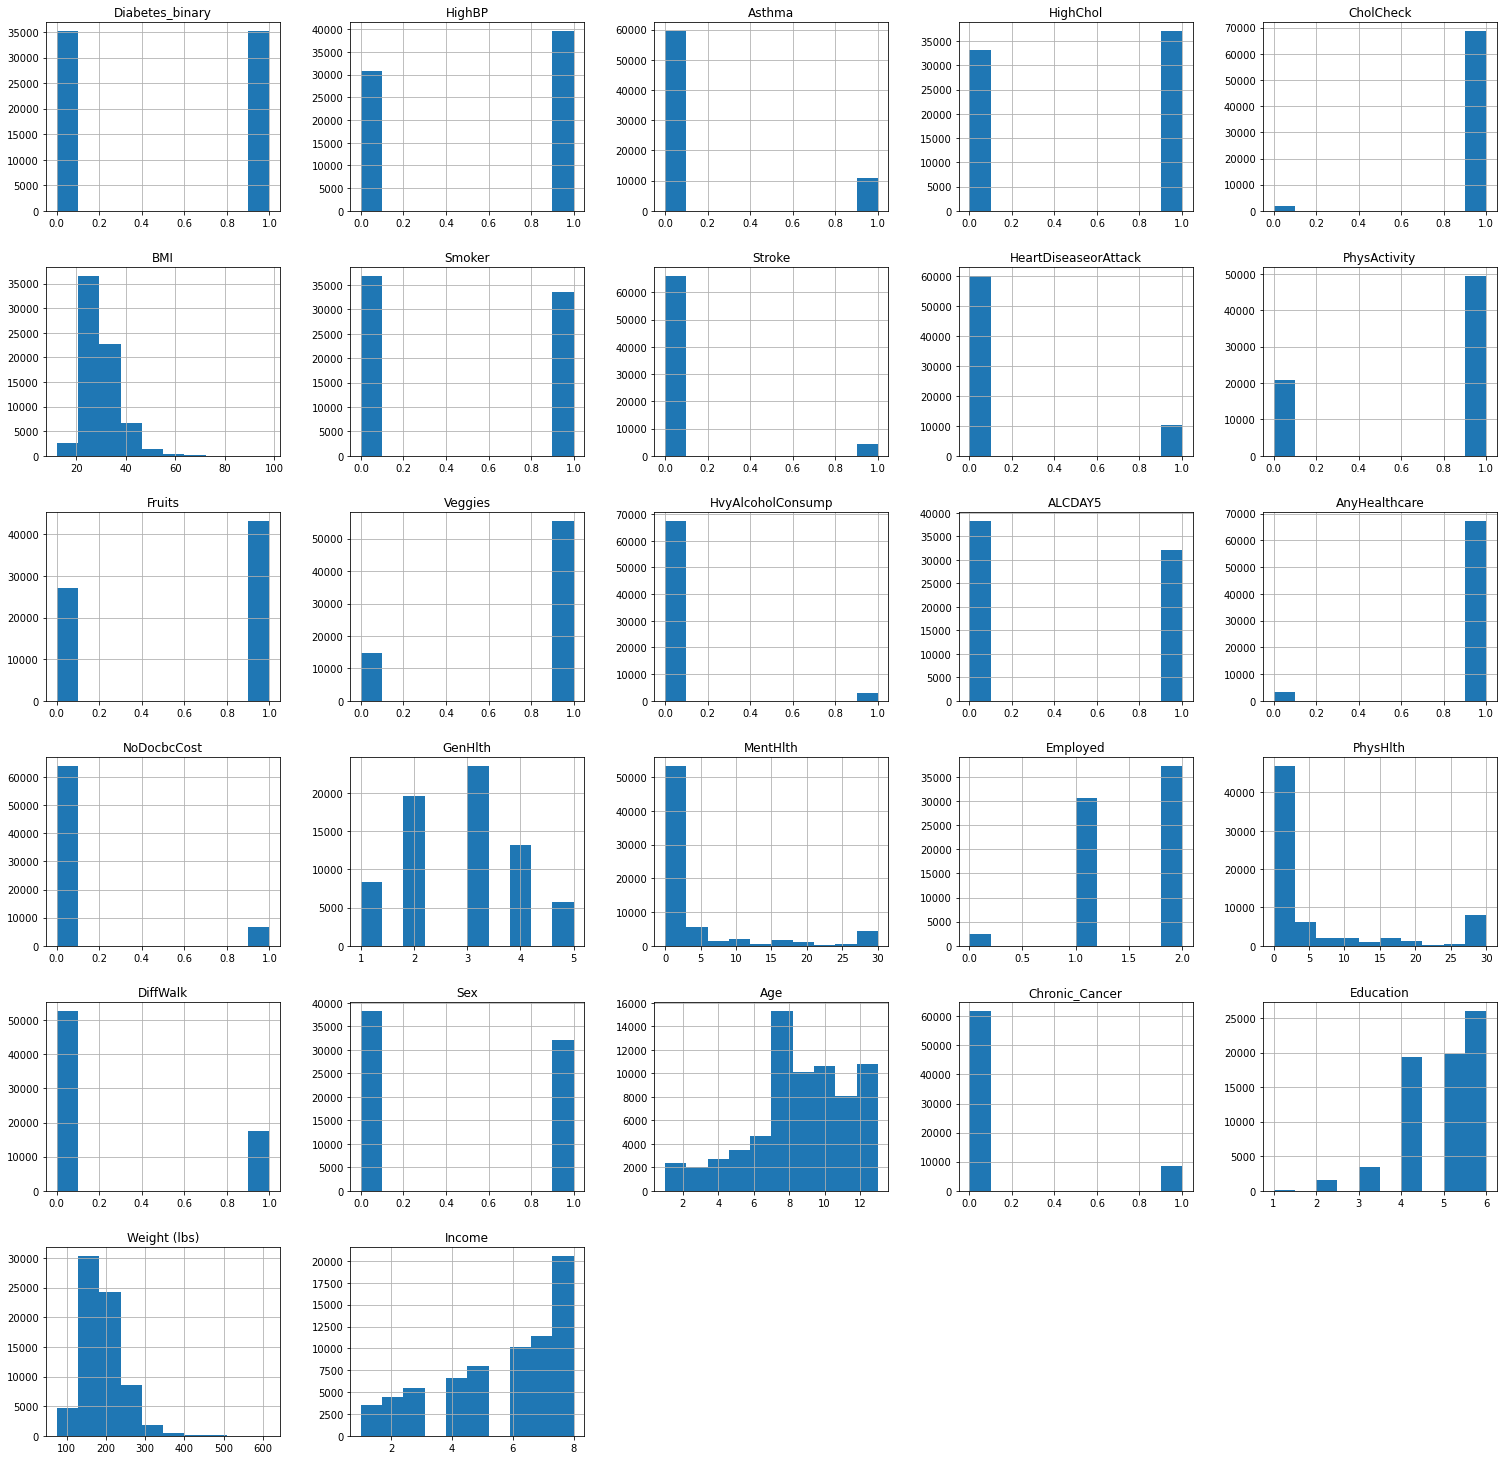

In [359]:
p = diab_df.hist(figsize = (26,26))


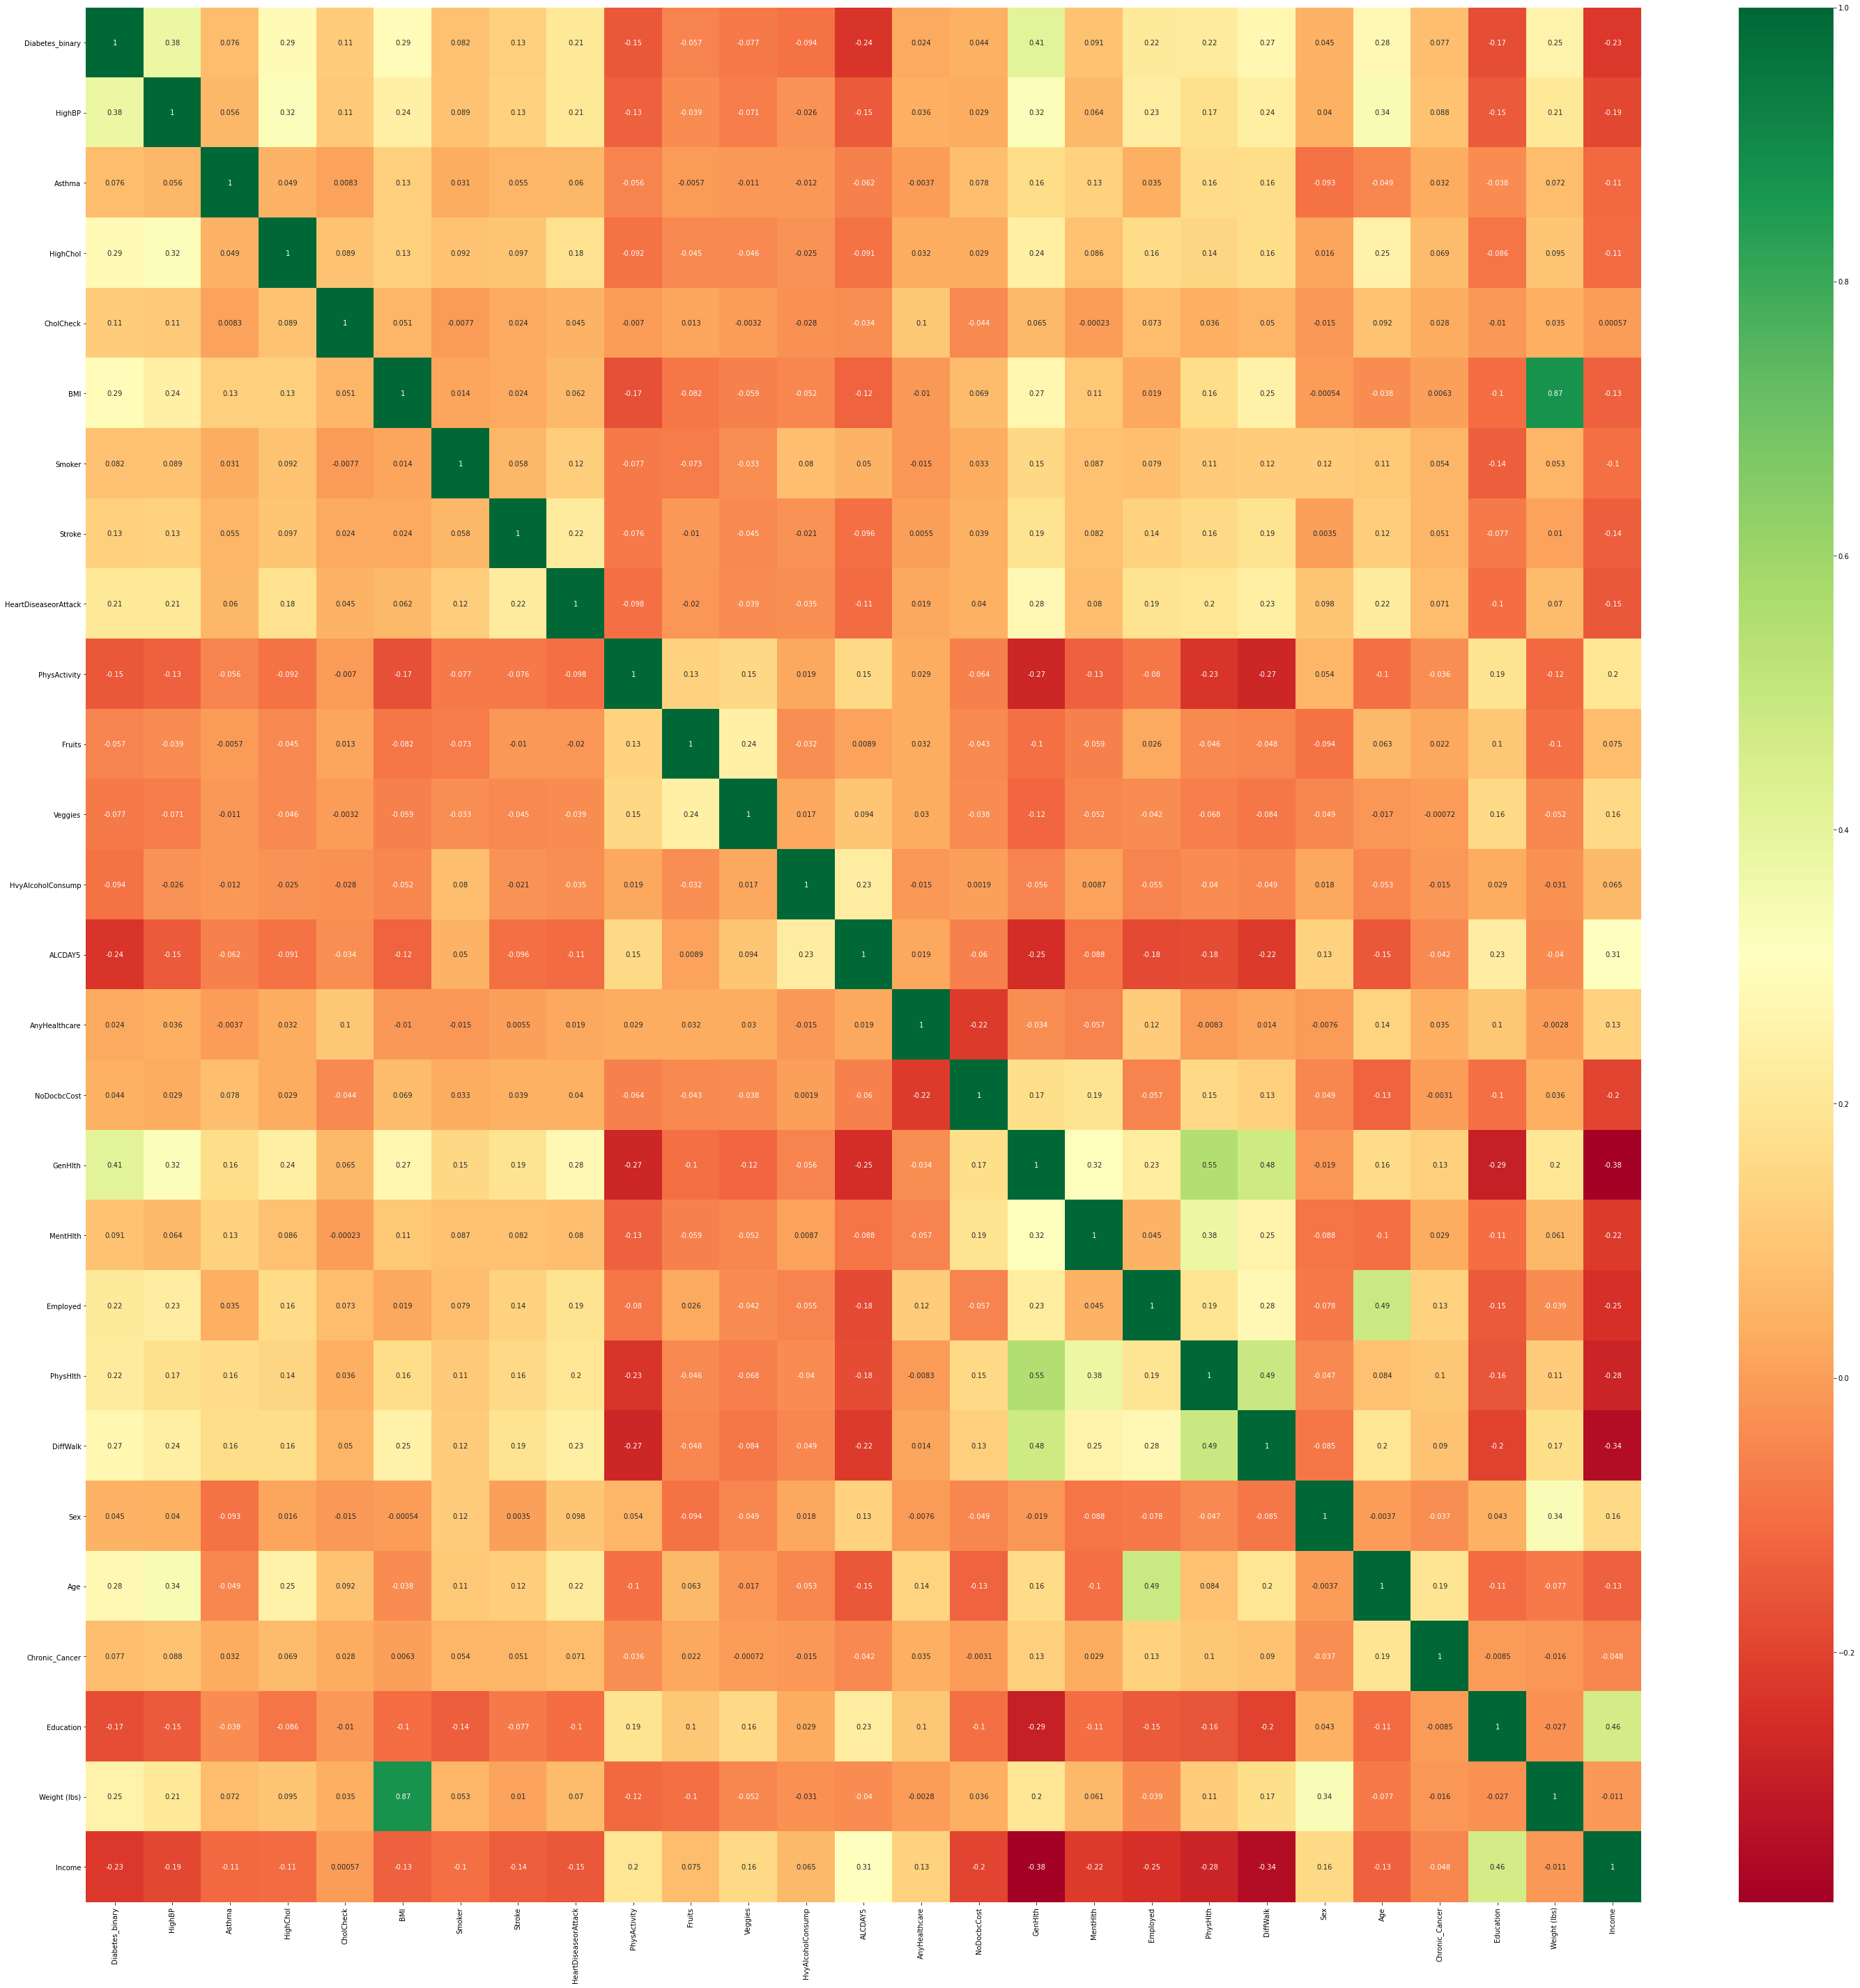

In [366]:
plt.figure(figsize=(50,50))
p = sns.heatmap(diab_df.corr(), annot=True,cmap ='RdYlGn')

## Scaling Data

Only Need to scale BMI PhysHLth, Weight, MentHlth

In [369]:
sc_X = StandardScaler()

In [371]:
# Define Features and targets as X and y

X =  pd.DataFrame(sc_X.fit_transform(diab_df.drop(["Diabetes_binary"],axis = 1),), columns=['BMI', 
'PhysHLth', 'Weight (lbs)', 'MentHlth', 'Age'])
X.head()
y = diab_df['Diabetes_binary']

ValueError: Shape of passed values is (70252, 26), indices imply (70252, 5)

In [350]:
X.head()

,HighBP,Asthma,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,ALCDAY5,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,Employed,PhysHlth,DiffWalk,Sex,Age,Chronic_Cancer,Education,Weight (lbs),Income
0,0.0,0.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,9.0,0.0,4.0,180.0,8.0
1,1.0,0.0,1.0,1.0,23.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,2.0,1.0,1.0,1.0,11.0,0.0,6.0,160.0,6.0
2,0.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,21.0,0.0,0.0,7.0,0.0,6.0,152.0,7.0
3,1.0,0.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,12.0,1.0,6.0,189.0,7.0
4,0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,5.0,185.0,5.0


In [351]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64